# SISSA - Language Reading and The Brain - a.y. 2023-24
# Sebastiano Quintavalle

## 1. Introduction

The purpose of this notebook is to analyze the results of an experiment carried out during an academic class, collected in the file `sound_symbolism.csv` (in order to automatically download the file from url, it is required to have first accessed basecamp in the browser and possibly updated the url in the `settings.py` file). 

The **22 students** in the class were made to listen to **32 words** in a language unfamiliar to them. These words referred to objects of **small size** or **large size**, and for each example the student was asked to indicate one of the two options.

### Data Preparation

Download the file and store it to a local directory.

In [2]:
from settings import DATA_URL, DATA_DIR, FILE_NAME
from io_ import DataDownloader

downloader = DataDownloader(url=DATA_URL, dir_path=DATA_DIR, file_name=FILE_NAME)

downloader

DataDownloader[file: C:\Users\user.LAPTOP-G27BJ7JO\Desktop\SISSA\CREPALDI\assigment1\data\sound_symbolism.csv; downloaded: True]

In [3]:
downloader.download()

Directory already exists: C:\Users\user.LAPTOP-G27BJ7JO\Desktop\SISSA\CREPALDI\assigment1\data
File downloaded at: C:\Users\user.LAPTOP-G27BJ7JO\Desktop\SISSA\CREPALDI\assigment1\data\sound_symbolism.csv


Once the file is downloaded, we load it as a [Data Frame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [4]:
from io_ import CSVLoader

loader = CSVLoader(file_path=downloader.file_path)
loader

CSVLoader[file: C:\Users\user.LAPTOP-G27BJ7JO\Desktop\SISSA\CREPALDI\assigment1\data\sound_symbolism.csv]

In [5]:
data = loader.load()

Loading C:\Users\user.LAPTOP-G27BJ7JO\Desktop\SISSA\CREPALDI\assigment1\data\sound_symbolism.csv ...
Complete


Let's inspect the first few rows.

In [6]:
data.head(10)

,word_id,sbj_id,response,word,language,meaning,is_sound_symbolic
0,word1,sbj1,big,dev,turkish,big,no
1,word1,sbj2,small,dev,turkish,big,no
2,word1,sbj3,big,dev,turkish,big,no
3,word1,sbj4,small,dev,turkish,big,no
4,word1,sbj5,small,dev,turkish,big,no
5,word1,sbj6,small,dev,turkish,big,no
6,word1,sbj7,small,dev,turkish,big,no
7,word1,sbj8,small,dev,turkish,big,no
8,word1,sbj9,big,dev,turkish,big,no
9,word1,sbj10,big,dev,turkish,big,no


## 2. Analysis

### Disclaimer

With the aim of making the analysis more linear in the notebook, the data were converted from a table form and a class architecture implemented and documented in `model.py`. This allows for clearer data modeling and allows one to focus solely on the results by demanding the implementation details to the classes.

### Experiment words

First we create the collection of words used during the experiment.

In [7]:
from model import Meaning, Word, Words

words_experiment = Words()
    
for row in data.loc[:, ['word_id', 'word', 'language', 'meaning', 'is_sound_symbolic']].drop_duplicates().itertuples(index=False):
    
    meaning = Meaning.from_string(row.meaning)
    is_sound_symbolic = row.is_sound_symbolic == "yes"
    
    new_word = Word(
        id_=row.word_id,
        word=row.word,
        language=row.language, 
        meaning=meaning,
        is_sound_symbolic=is_sound_symbolic
    )

    words_experiment.add_word(word=new_word)

Words are equally distributed by large and small.

In [8]:
words_experiment

Words[count: 32, small: 16, big: 16]

We can identify two simple characteristics for a set of words, **average length** and **vowel distribution**.

The distribution of vowels is fairly balanced in the word set.

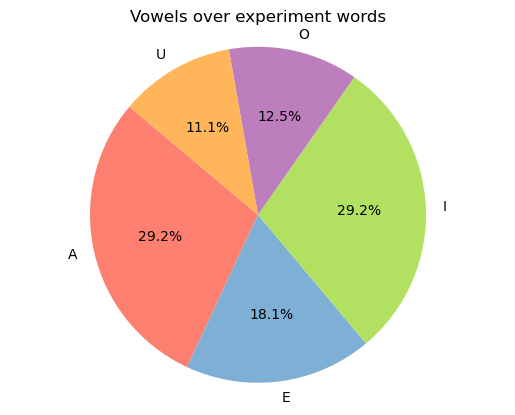

In [9]:
words_experiment.plot_vowels_distr(title="Vowels over experiment words")

The average length.

In [10]:
print(f"Average length: {words_experiment.avg_length}")

Average length: 5.375


Let's separate the words into small and big.

In [11]:
words_experiment_small, words_experiment_big = words_experiment.get_meaning_split()

print(words_experiment_small)
print(words_experiment_big)

Words[count: 16, small: 16, big: 0]
Words[count: 16, small: 0, big: 16]


The distribution of vowels between the two types of meanings shows a clear pattern: words referring to **something small** tend to make predominant use of the vowel ***I***, while words referring to **something large** make predominant use of ***A***. Intuitively, this may be motivated by the fact that the *A* is an **open vowel**, that is, it is produced with as much space as possible between the tongue and palate and may therefore refer to a **concept of extension**. In contrast, the **closed sound** of the *I* may somehow evoke something **smaller in size**.

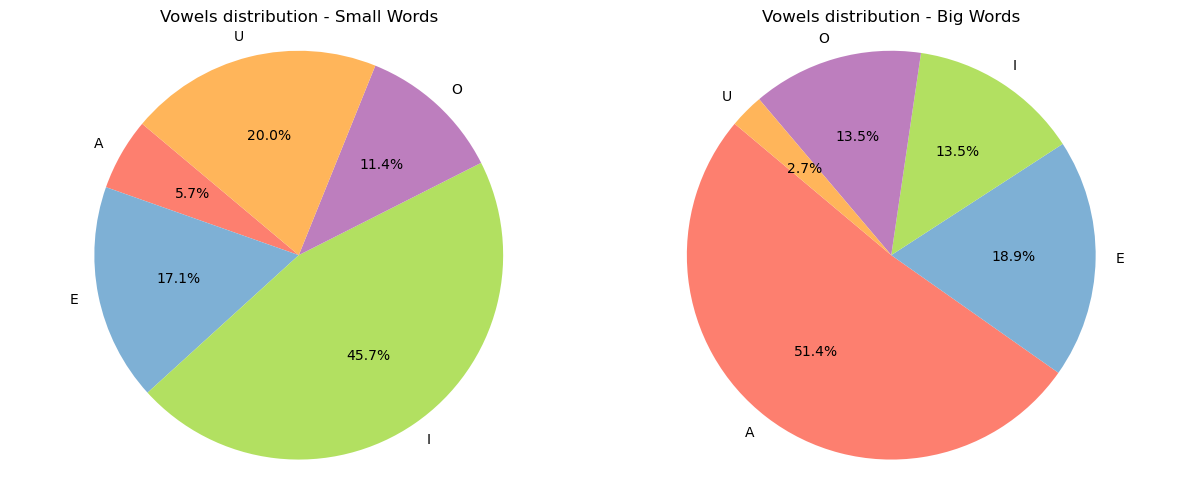

In [12]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
words_experiment_small.plot_vowels_distr(ax=axes[0], title="Vowels distribution - Small Words")
words_experiment_big.  plot_vowels_distr(ax=axes[1], title="Vowels distribution - Big Words"  )

plt.tight_layout()
plt.show()

The average length does not reveal a clear pattern.

In [13]:
print("Average length:")
print(f" - Small words: {words_experiment_small.avg_length}")
print(f" - Big   words: {words_experiment_big  .avg_length}")

Average length:
 - Small words: 5.125
 - Big   words: 5.625


### Subjects

Let's add **experiment information**. The set of responses given by a single subject is considered as an experiment. The experiments are then grouped into a single collection.

In [14]:
from model import Subject, Experiments

experiments = Experiments(words=words_experiment)

subject_ids = data.loc[:, "sbj_id"].unique().tolist()

for subject_id in subject_ids:
    
    # Create new subject
    new_subject = Subject(id_=subject_id)
    
    # Add answers
    for row in data[data.loc[:, "sbj_id"] == subject_id].itertuples(index=False):
        
        new_subject.add_answer(
            word_id=row.word_id,
            answer=Meaning.from_string(s=row.response)
        )
    
    experiments.add_subject(subject=new_subject)

In [15]:
experiments

Experiment[Subjects: 22 - Mean score: 0.646]

We first analyze the proportion of small vs large responses given by each subject. The distribution of responses is **fairly balanced for each subject**. Thus we can think they had a notion of the distribution of words in the experimental set, that was also balanced.

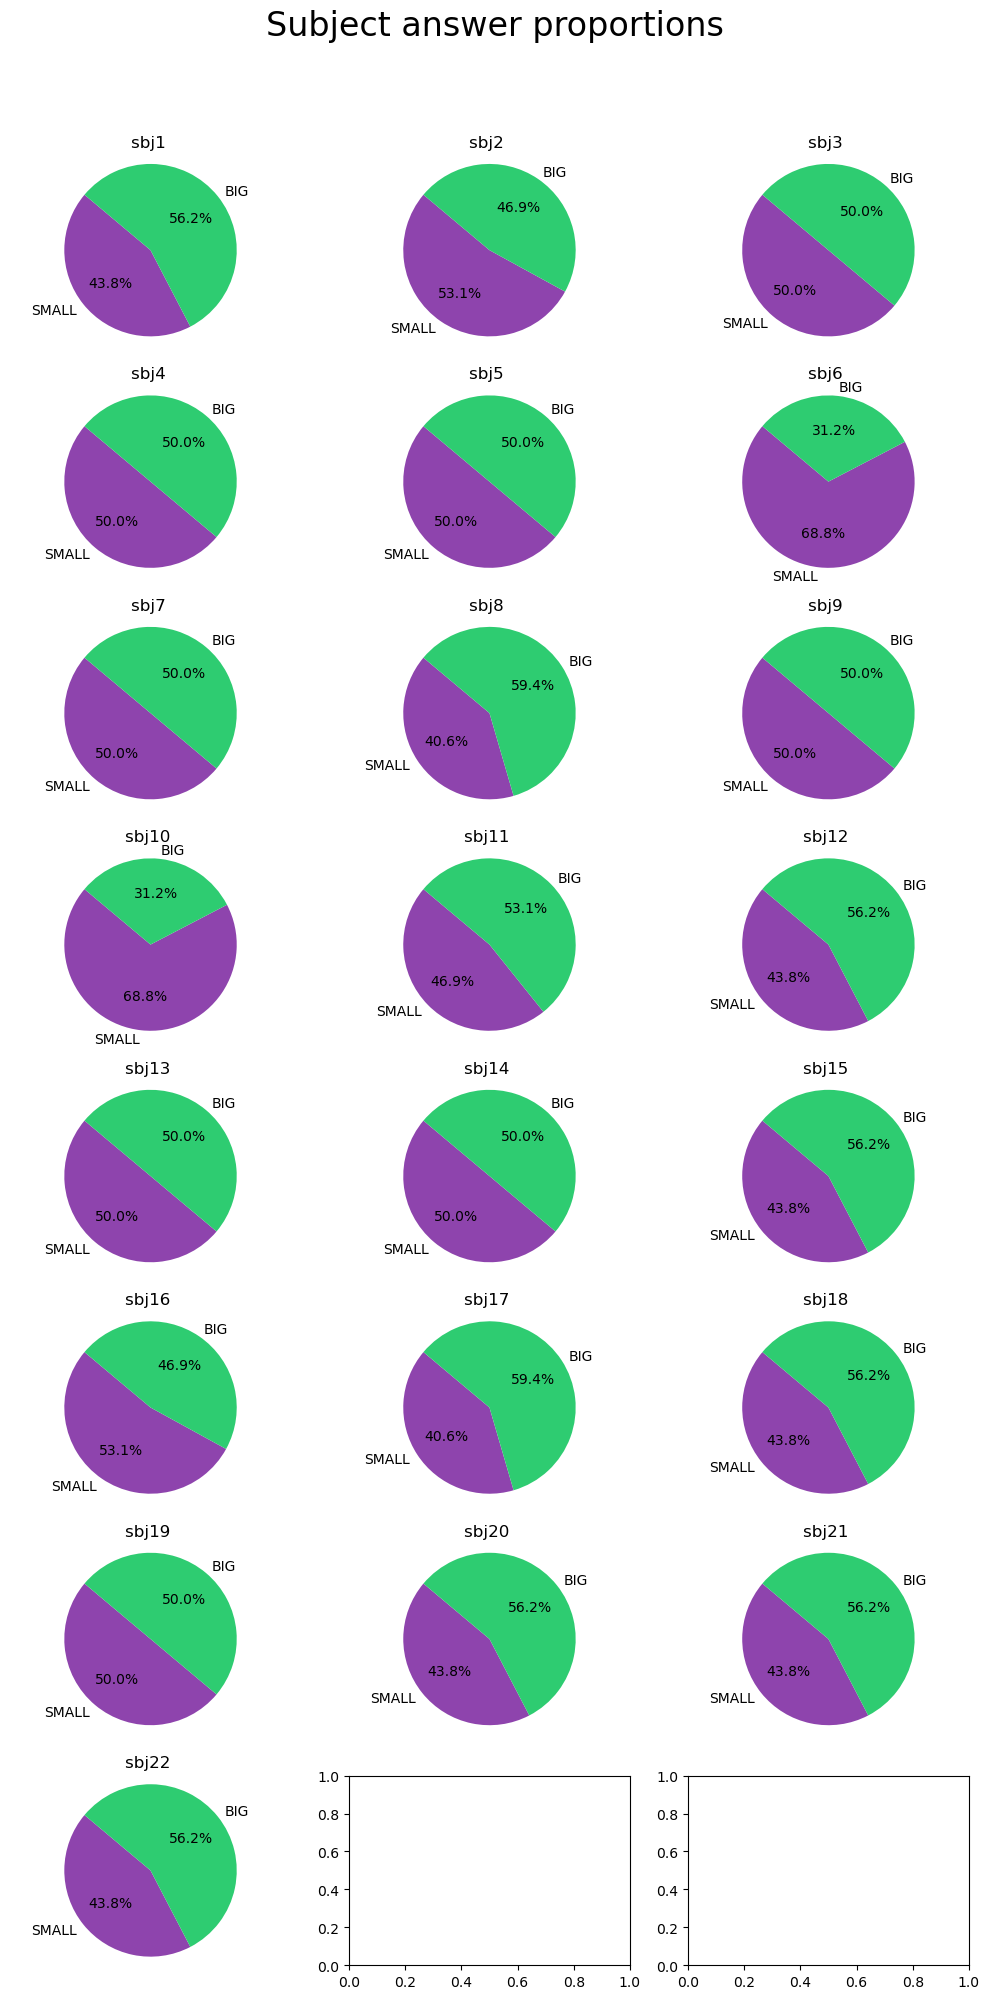

In [16]:
import matplotlib.pyplot as plt

N_COL = 3
N_ROW = 8

fig, axes = plt.subplots(N_ROW, N_COL, figsize=(10, 21))

for i in range(N_COL * N_ROW):
    
    if i >= len(experiments):
        break
        
    row = i // N_COL
    col = i % N_COL
    
    experiments[subject_ids[i]].subject.plot_answer_count(ax=axes[row, col], title="")
    
# Add a main title
fig.suptitle("Subject answer proportions", fontsize=24)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Subject Scores

Let's now consider the subjects' responses based on the true meaning of the word and calculate the **percentage of correct answers**.

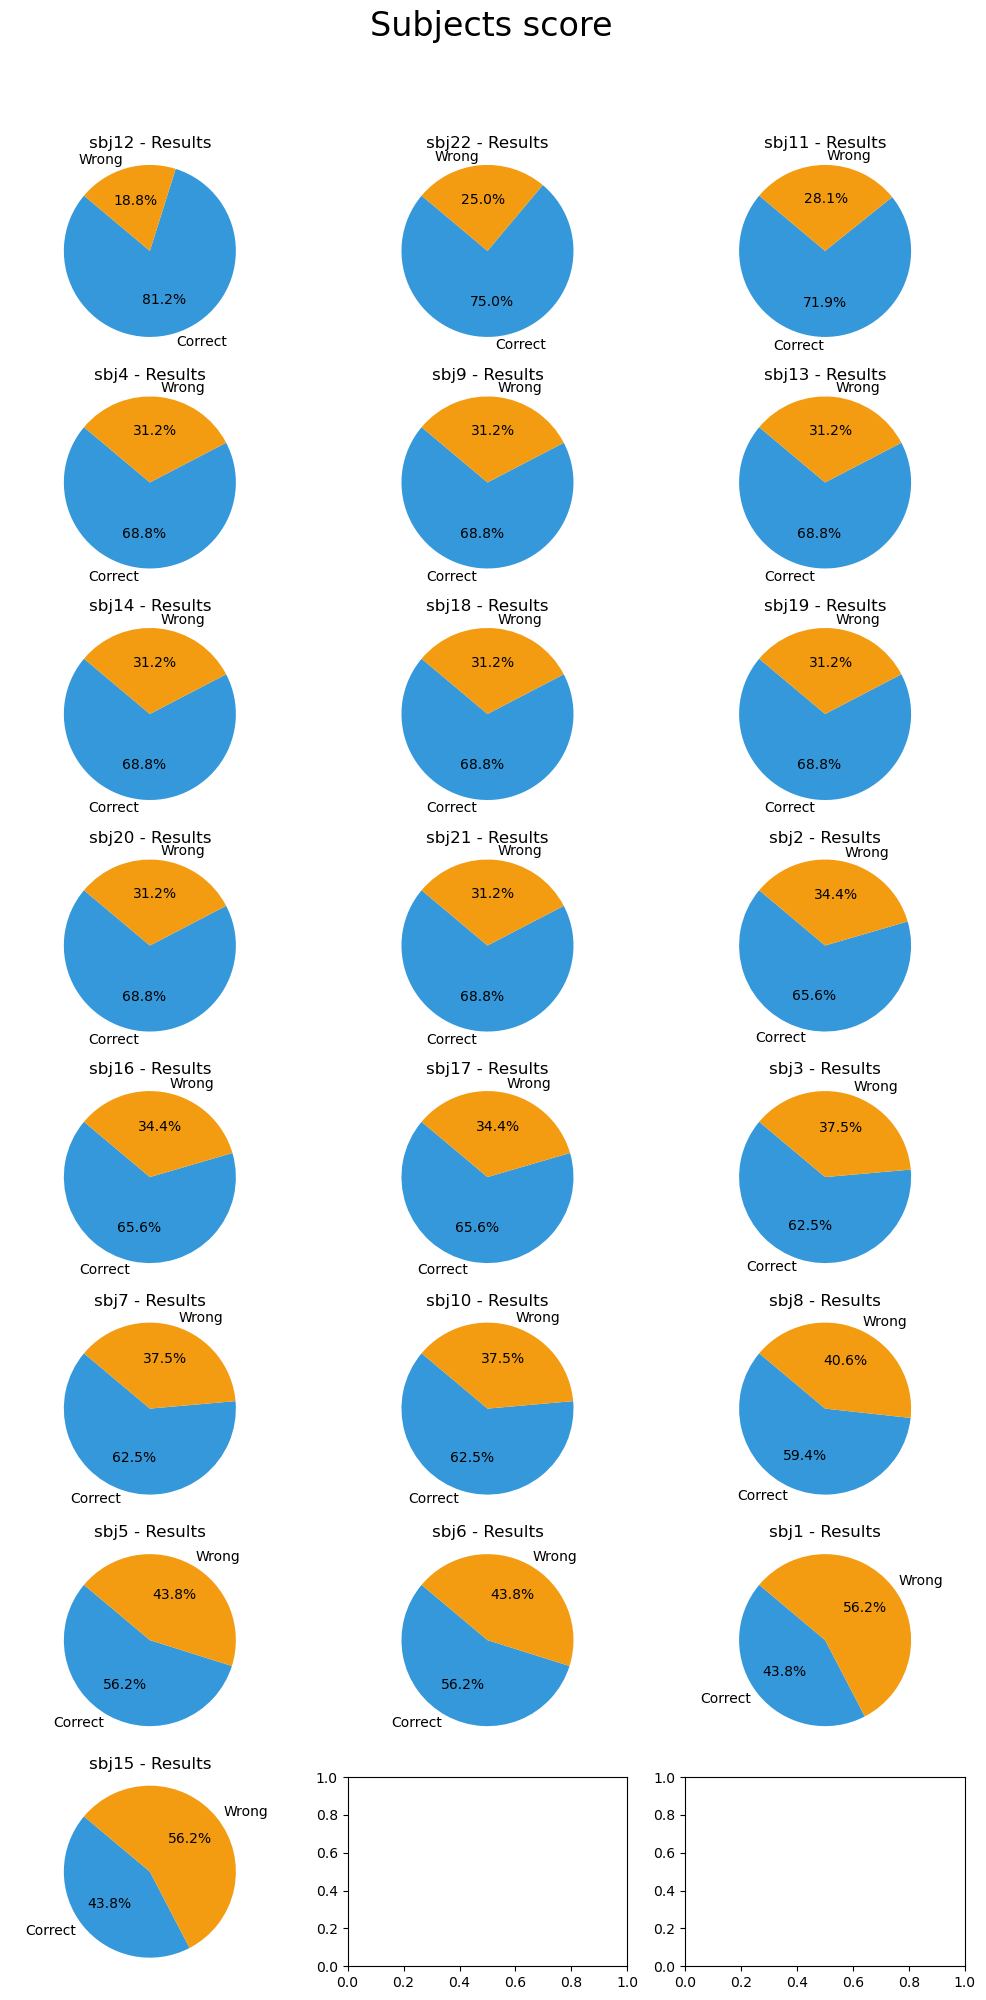

In [17]:
experiments.plot_subjects_scores(n_row=8, by_score=True)

The balanced distribution of meanings in words allows us to establish a baseline at 50%, achieved by a subject who doesn't listen to the words but simply guesses for each example. On average, **subjects perform 10% above the baseline**.

In [18]:
print(f"Mean score: {round(experiments.mean_score, 3)}")

Mean score: 0.646


The subject with the **highest score** achieved an **excellent result** of 80%, well above the average, while the one with the **lowest score** is only **slightly below the baseline**.

In [19]:
_, best  = experiments.sort_by_score()[0]
_, worst = experiments.sort_by_score()[-1]

print(f"Best  subject: {best} ")
print(f"Worst subject: {worst}")

Best  subject: Experiment sbj12[Score: 0.8125] 
Worst subject: Experiment sbj15[Score: 0.4375]


Let's inspect the confusion matrixes of the two subjects.

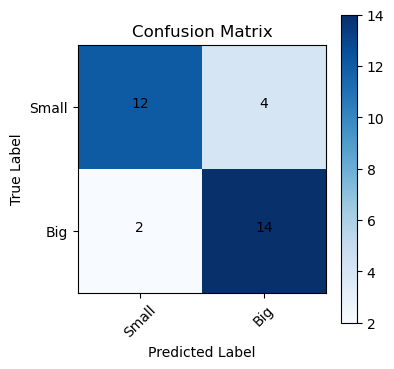

In [20]:
best.plot_confusion_matrix()

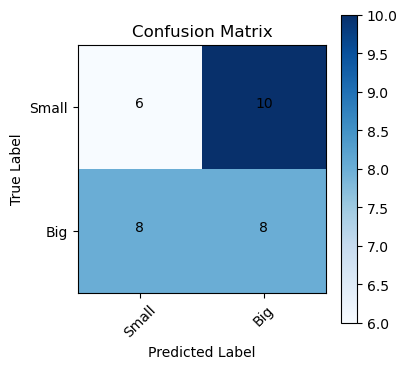

In [21]:
worst.plot_confusion_matrix()

Let's see the words the best subject did't get correct.

In [22]:
for word in best.words_wrong:
    print(f"{word.word:>8} {'('+word.language+')':>12} - {word.meaning}")

   vogel   (albanian) - small
    gede (indonesian) - big
  vocerr   (albanian) - small
    tobi     (yoruba) - big
hen xiao   (mandarin) - small
     wei   (mandarin) - small


And the words the worst subject got correct.

In [23]:
for word in worst.words_correct:
    print(f"{word.word:>11} {'('+word.language+')':>12} - {word.meaning}")

      vogel   (albanian) - small
    raksasa (indonesian) - big
      besar (indonesian) - big
         xi   (mandarin) - small
    pang da   (mandarin) - big
     ghanda   (gujarati) - big
       kort      (dutch) - small
      vigan   (albanian) - big
      kutti      (tamil) - small
        wei   (mandarin) - small
    niraiya      (tamil) - big
ko de ha da     (korean) - big
     tintin     (yoruba) - small
 koskocaman    (turkish) - big


There's no a clear pattern in these answers.

### Vowel subject

Let's try applying the technique to the distribution of vowels by creating a subject who answers "small" when *I* predominated and answers "big" predominantly for the vowel *A*.

In [24]:
from model import Experiment

vowel_subject = Subject(id_="vowel")

for word in words_experiment:
    
    n_a = word.vowels_count['a']
    n_i = word.vowels_count['i']
    
    answer = Meaning.SMALL if n_i > n_a else Meaning.BIG
    
    vowel_subject.add_answer(word_id=word.id_, answer=answer)

vowel_experiment = Experiment(subject=vowel_subject, words=words_experiment)

The score of this subject corresponds to guessing 3 words out of 4, and it **performs better than the average of the subjects**. Specifically, it ties with *subject 22* and loses to *subject 12* but beats all the others.

In [25]:
print(f"Vowel subject score: {vowel_experiment.score}")

Vowel subject score: 0.75


### Word answers

We are now interested in the words and the **distribution between the two classes** (without considering the true label at the moment).

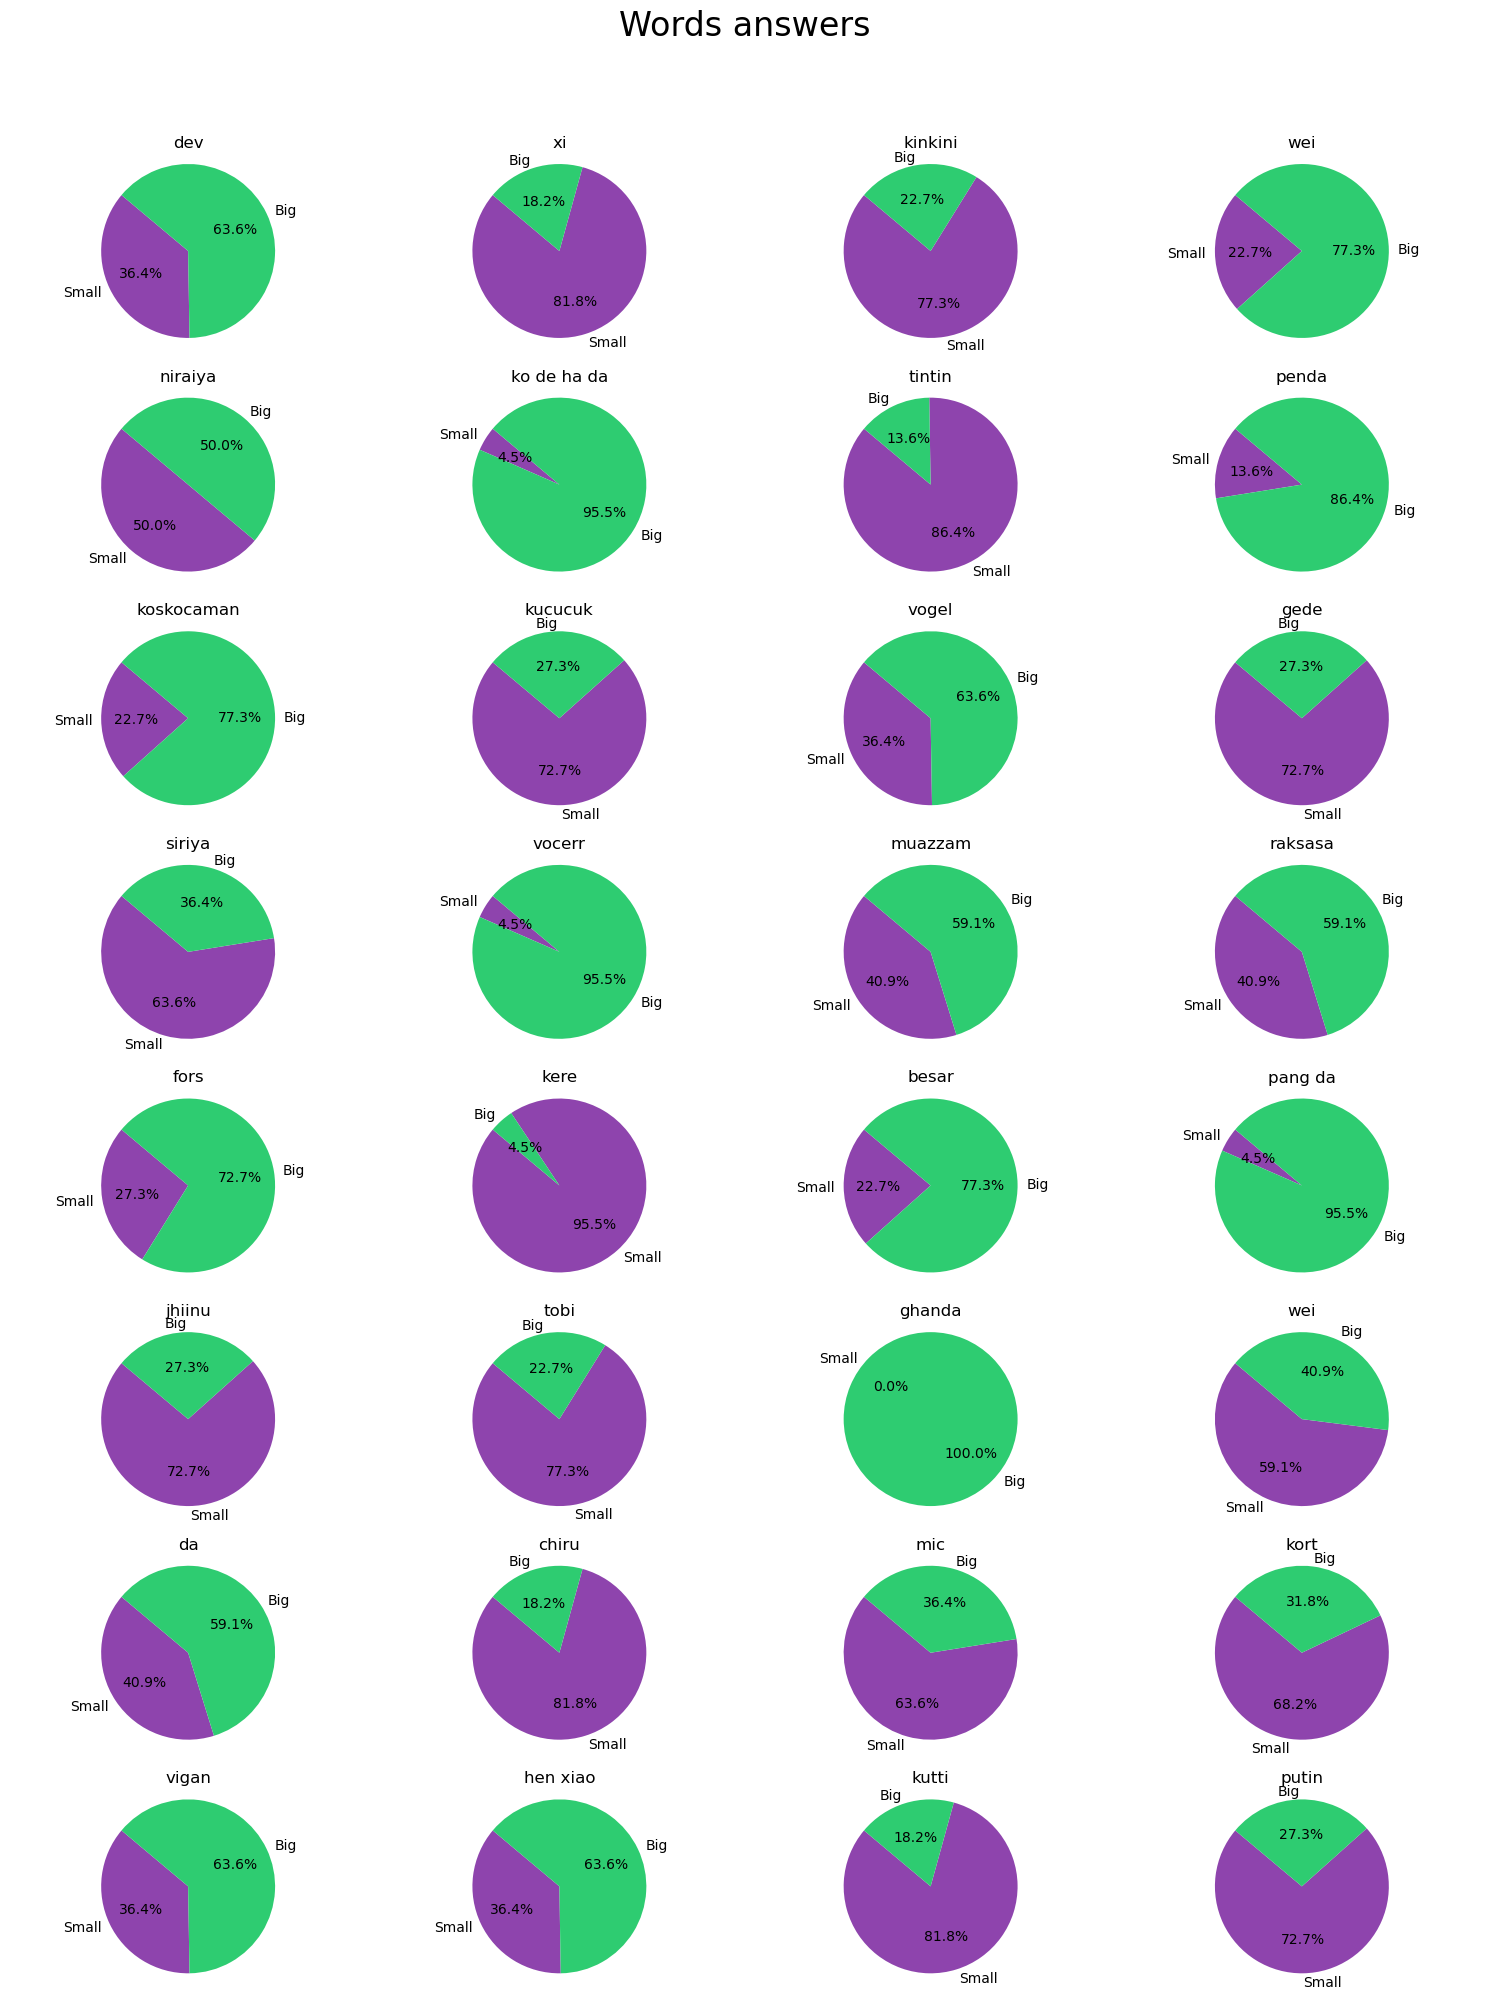

In [26]:
experiments.plot_words_answers(n_row=8)

The result is *highly variable**, so let's analyze the level of proportionality of responses using five different bins based on the **degree of imbalance**. Bins are more or less balanced, but the fact that there are many cases where responses are unbalanced suggests that **subjects** may share a **common pattern** that pushes the answer towards one of the two classes.

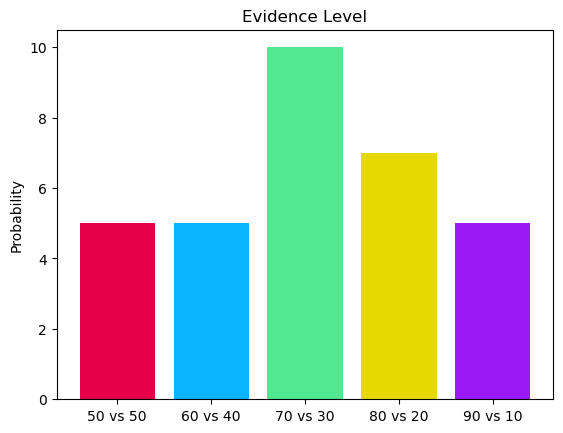

In [27]:
experiments.plot_evidence()

Let's inspect words leading to ties and ones leading to a strong imbalance.

In [28]:
print("No evidence")

for word in experiments.get_evidence()["None"]:
    print(f" - {word.word:>11} {'('+word.language+')':<12} - {str(word.meaning).capitalize():>5}")
  
print()  
print("Strong evidence")

for word in experiments.get_evidence()["Strong"]:
    print(f" - {word.word:>11} {'('+word.language+')':<12} - {str(word.meaning).capitalize():>5}")

No evidence
 -     niraiya (tamil)      -   Big
 -     muazzam (turkish)    -   Big
 -     raksasa (indonesian) -   Big
 -         wei (mandarin)   -   Big
 -          da (mandarin)   -   Big

Strong evidence
 - ko de ha da (korean)     -   Big
 -      vocerr (albanian)   - Small
 -        kere (yoruba)     - Small
 -     pang da (mandarin)   -   Big
 -      ghanda (gujarati)   -   Big


### Word scores

We take know into account words answer with respect to the true classes. The results are **fairly balanced**, there emerge both scenarios where the **vast majority of subjects** was able to **guess the correct label** and cases in which **most of them got wrong**.

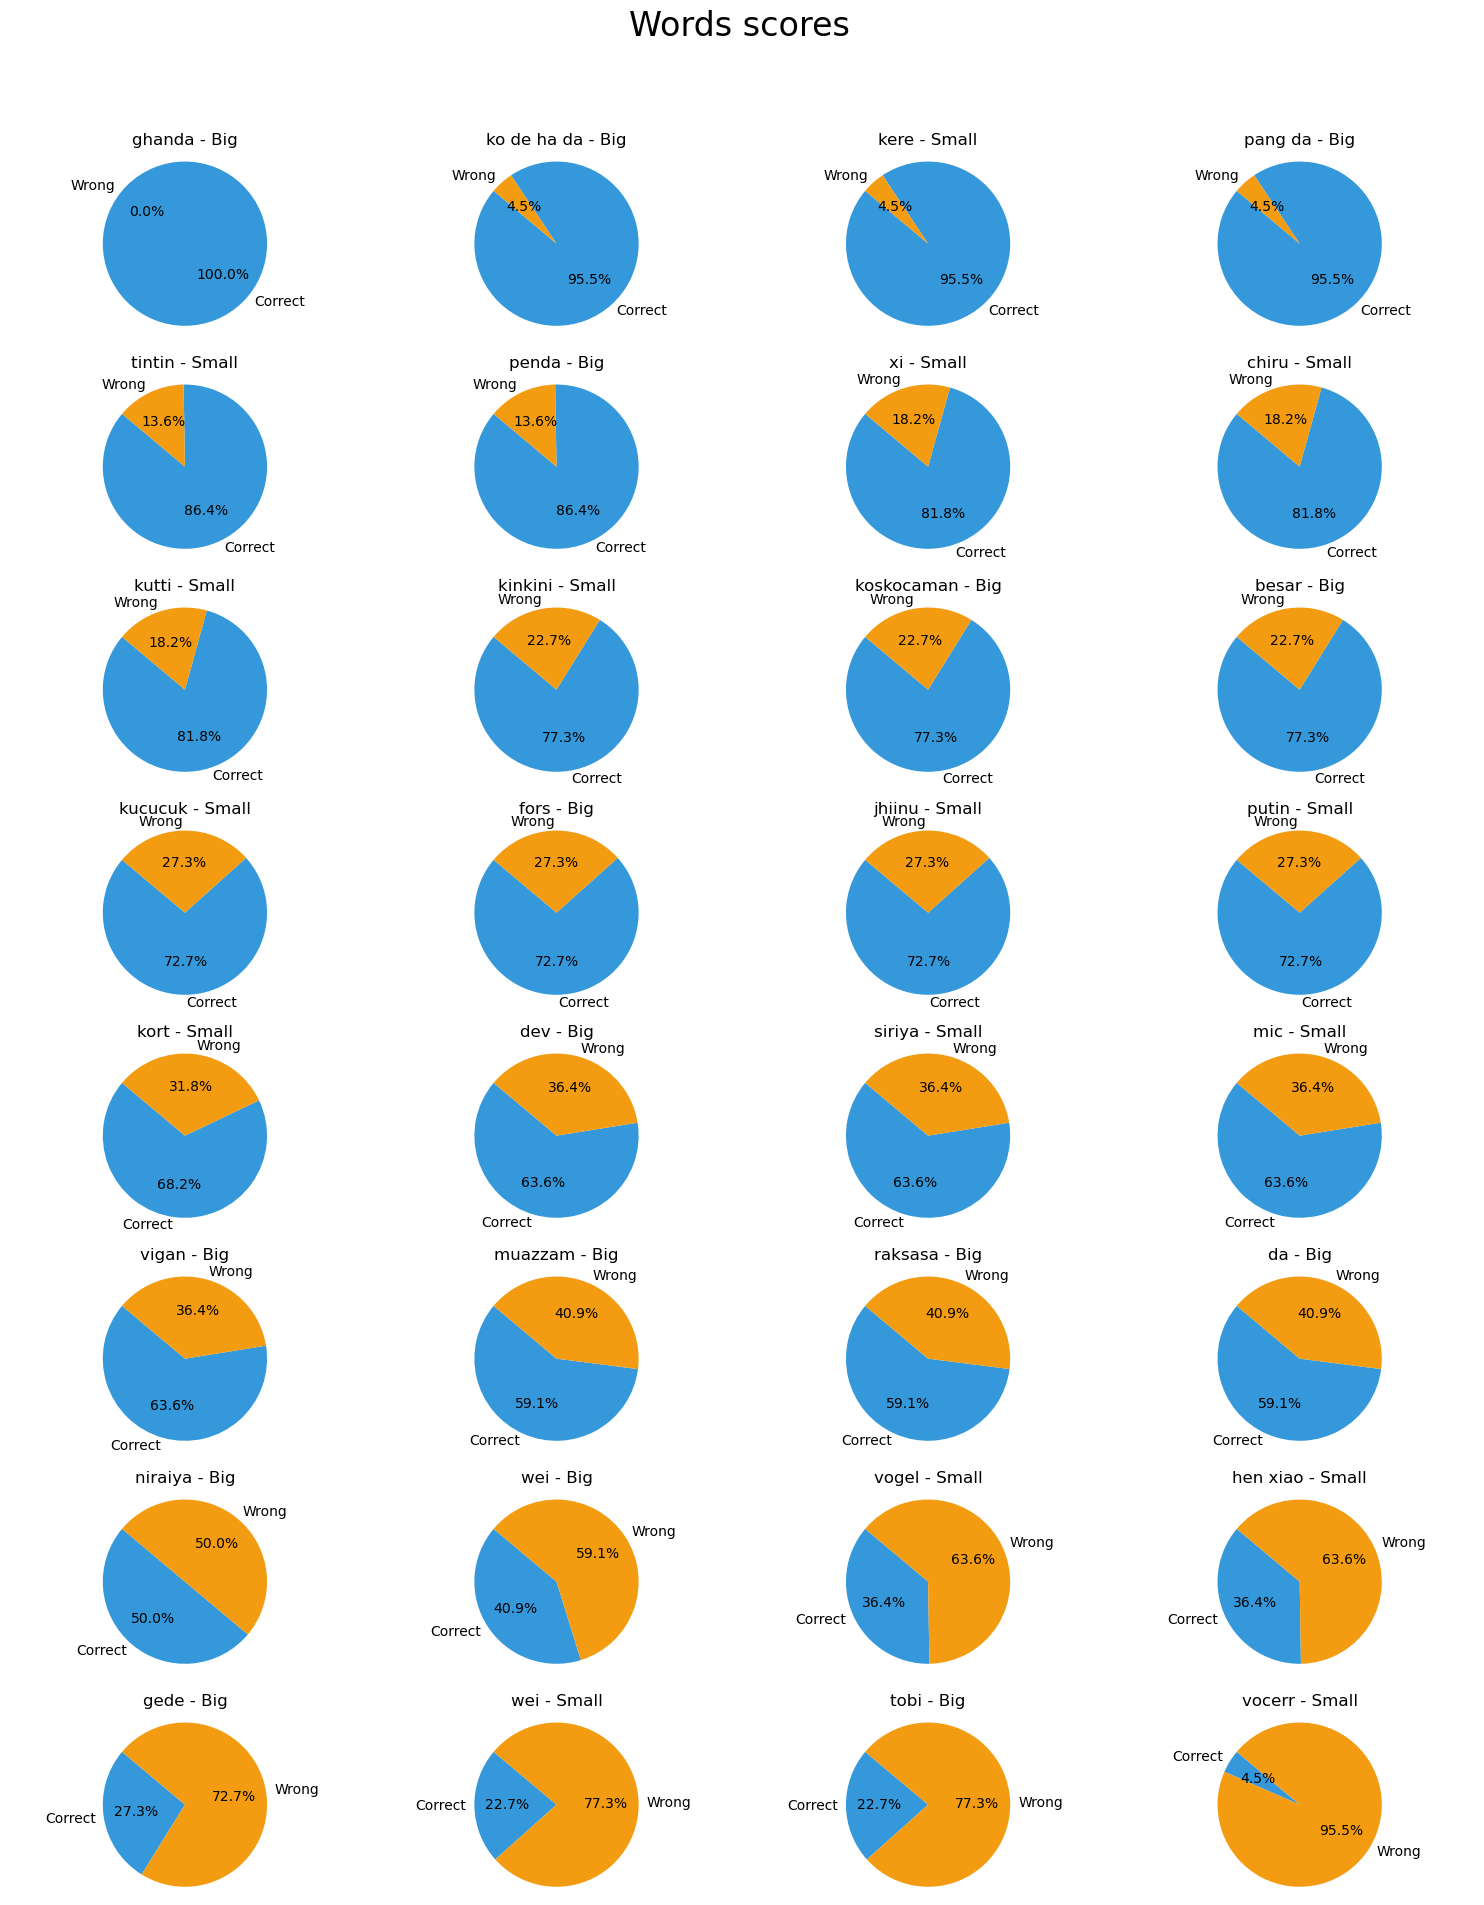

In [29]:
experiments.plot_words_scores(n_row=8, sort=True)

Let's print the same type of information including information about the language.

In [30]:
word_scores = experiments.get_words_results(sort=True)

for word_id, correct in word_scores:
    word = words_experiment[word_id]
    print(f" - {word.word:>11} {'('+word.language+')':<12} - {str(word.meaning).capitalize():>5}: [{correct:>2}]/[{len(experiments)}]")

 -      ghanda (gujarati)   -   Big: [22]/[22]
 - ko de ha da (korean)     -   Big: [21]/[22]
 -        kere (yoruba)     - Small: [21]/[22]
 -     pang da (mandarin)   -   Big: [21]/[22]
 -      tintin (yoruba)     - Small: [19]/[22]
 -       penda (gujarati)   -   Big: [19]/[22]
 -          xi (mandarin)   - Small: [18]/[22]
 -       chiru (tamil)      - Small: [18]/[22]
 -       kutti (tamil)      - Small: [18]/[22]
 -     kinkini (yoruba)     - Small: [17]/[22]
 -  koskocaman (turkish)    -   Big: [17]/[22]
 -       besar (indonesian) -   Big: [17]/[22]
 -     kucucuk (turkish)    - Small: [16]/[22]
 -        fors (dutch)      -   Big: [16]/[22]
 -      jhiinu (gujarati)   - Small: [16]/[22]
 -       putin (romanian)   - Small: [16]/[22]
 -        kort (dutch)      - Small: [15]/[22]
 -         dev (turkish)    -   Big: [14]/[22]
 -      siriya (tamil)      - Small: [14]/[22]
 -         mic (romanian)   - Small: [14]/[22]
 -       vigan (albanian)   -   Big: [14]/[22]
 -     muazza

### 3. Neural network

### Disclimer

The process of selecting and training the neural network doesn't follow the usual pipeline. There is no hyperparameter tuning, and there's no evaluation of a validation loss to stop the training process, likely leading to overfitting.

This is because the ultimate goal is not to train a high-performing network but to analyze its behavior on a task analogous to that given to human subjects.

### Training

The previous analyses suggest that subjects are capable of perceiving a **common pattern** within the word that may be **correlated with the type of meaning**. It can be assumed that this ability stems from being exposed in everyday life to words that refer to the two classes. To simulate this phenomenon, let's **train a neural network** that, given a **word as input**, outputs the **probability that it refers to a large or small object**.


Since the vast majority of subjects are native **Italian** speakers who also know **English** well, let's use words that refer to these two languages for the training of the neural network.

Words are listed in `small.txt` and `big.txt`.

In [31]:
from io_ import TXTLoader
from settings import SMALL_WORDS_FILE, BIG_WORDS_FILE

small_words_tokens = TXTLoader(file_path=SMALL_WORDS_FILE).load()
big_words_tokens   = TXTLoader(file_path=  BIG_WORDS_FILE).load()

Let's see some example.

In [32]:
import random

print("Small words")
for small_word in random.sample(small_words_tokens, 10):
    print(f"- {small_word}")
    
print()
print("Big words")
for big_word in random.sample(big_words_tokens, 10):
    print(f"- {big_word}")

Small words
- stuzzicadenti
- ovatta
- fichetto
- pallottola
- tessuto
- grano di riso
- medaglia
- conchiglia
- lapis
- segnaposto

Big words
- municipality
- asteroid
- cascata
- fiume
- casolare
- famiglia
- idrovolante
- carousel
- pianeta
- asciugatrice


Let's create the collection.

In [33]:
words_training = Words()

for i, small_word in enumerate(small_words_tokens, start=1):
    
    new_word = Word(
        id_=f"sw{i}",
        word=small_word,
        language="it/eng", 
        meaning=Meaning.from_string('small'),
        is_sound_symbolic=False
    )
    
    words_training.add_word(word=new_word)
    
for i, big_word in enumerate(big_words_tokens, start=1):
    
    new_word = Word(
        id_=f"bw{i}",
        word=big_word,
        language="it/eng", 
        meaning=Meaning.from_string('big'),
        is_sound_symbolic=False
    )
    
    words_training.add_word(word=new_word)

In [34]:
words_training

Words[count: 725, small: 311, big: 414]

The clear distribution of vowels doesn't repeat as with the experiment words.

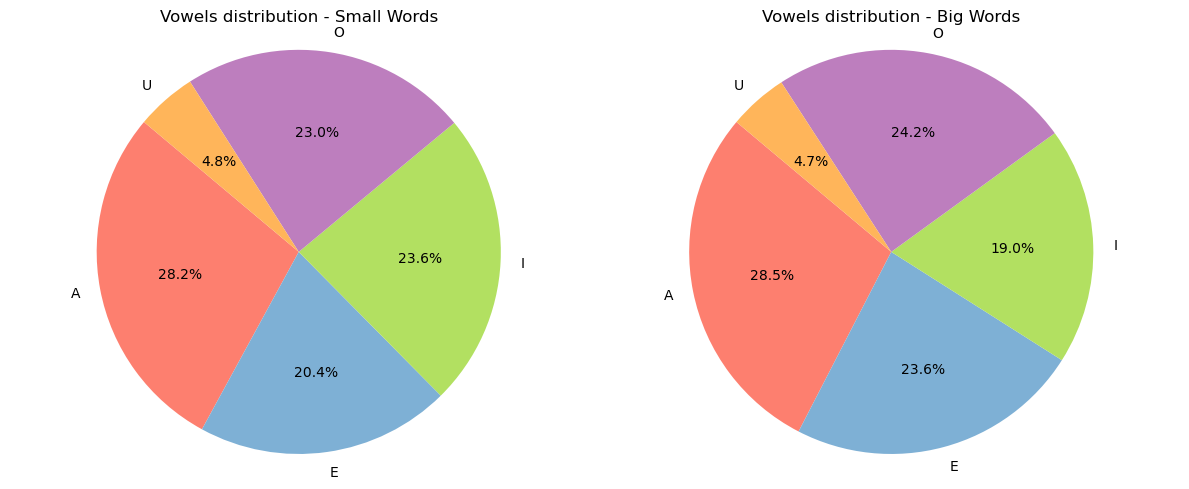

In [35]:
words_training_small, words_training_big = words_training.get_meaning_split()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
words_training_small.plot_vowels_distr(ax=axes[0], title="Vowels distribution - Small Words")
words_training_big.  plot_vowels_distr(ax=axes[1], title="Vowels distribution - Big Words"  )

plt.tight_layout()
plt.show()

We will use a type of **recurrent neural network** (RNN) that operates at the **character level**. This neural network is useful for capturing interdependencies in word construction (it iss, for instance, an excellent use case for the classification of surnames in various languages).

We need to create our own alphabet.

In [36]:
from network import Alphabet

alphabet = Alphabet()

for word in words_training:
    alphabet.add_word(word=word.word)
    
alphabet

Alphabet[size: 31]

The network has an hyperparameter, the **hidden-size** which we fix to 50.

In [37]:
from network import MeaningClassifier

HIDDEN_SIZE = 50

model = MeaningClassifier(
    alphabet=alphabet,
    hidden_size=HIDDEN_SIZE,
)

model

MeaningClassifier(
  (input_to_hidden): Embedding(31, 25)
  (hidden_to_hidden): Linear(in_features=50, out_features=25, bias=True)
  (hidden_to_output): Linear(in_features=50, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

We create training configurations.

In [38]:
from settings import DEVICE
from network import ModelConfig

config = ModelConfig(
    epochs=10000,
    epochs_log=150,
    lr=0.001,   
    device=DEVICE
)

config

ModelConfig[epochs: 10000; epochs-log: 150; lr: 0.001; device: cpu]

Let's train the network.

In [39]:
from network import Trainer

trainer = Trainer(
    words=words_training,
    model=model,
    config=config
)

In [40]:
%time
inference = trainer.train()

CPU times: total: 0 ns
Wall time: 0 ns
Epoch: 150 (1.5%)
  Loss:        0.42324262857437134
  Word:        lavastoviglie
  Meaning:     big
  Prob. Small: 0.34508028626441956
  Prob. Big:   0.6549197435379028
Epoch: 300 (3.0%)
  Loss:        0.36931920051574707
  Word:        match
  Meaning:     small
  Prob. Small: 0.6912047266960144
  Prob. Big:   0.3087952435016632
Epoch: 450 (4.5%)
  Loss:        0.79610675573349
  Word:        cerniera
  Meaning:     small
  Prob. Small: 0.4510817229747772
  Prob. Big:   0.5489183068275452
Epoch: 600 (6.0%)
  Loss:        0.4740540683269501
  Word:        associazione
  Meaning:     big
  Prob. Small: 0.3775264024734497
  Prob. Big:   0.6224735975265503
Epoch: 750 (7.5%)
  Loss:        0.5602753758430481
  Word:        globulo
  Meaning:     small
  Prob. Small: 0.5710517764091492
  Prob. Big:   0.42894822359085083
Epoch: 900 (9.0%)
  Loss:        0.2746375799179077
  Word:        shoe store
  Meaning:     big
  Prob. Small: 0.240152508020401
  P

The training loss decreases initially but then stabilizes and begins to oscillate, indicating that a certain learning capacity has been achieved.

### Model analysis

The training loss decreases initially but then stabilizes and begins to oscillate, indicating that a certain learning capacity has been achieved.

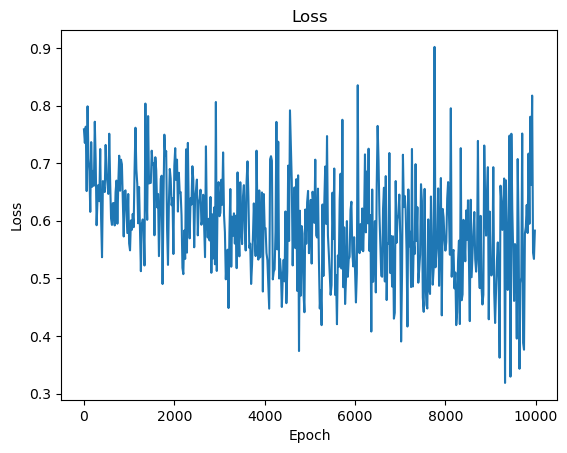

In [41]:
inference.plot_loss(title="Loss")

The confusion matrix is satisfactory, but perhaps it's indicative of overfitting. For this reason, we also evaluate the model on a test set that hasn't been seen during training to ensure a more comprehensive assessment.

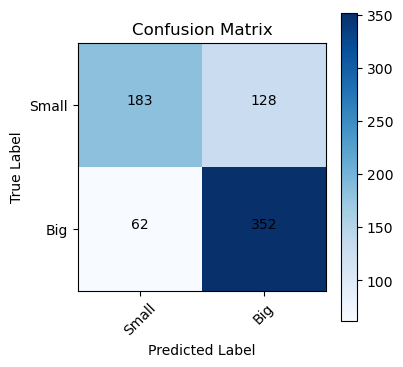

In [42]:
inference.plot_confusion_matrix(words=words_training)

Let's also evaluate predictions on a test set. The model is probably prone to predict "big" class as it's baised on the training set which contains more big words.

In [43]:
from settings import SMALL_WORDS_FILE_TEST, BIG_WORDS_FILE_TEST

small_words_test_tokens = TXTLoader(file_path=SMALL_WORDS_FILE_TEST).load()
big_words_test_tokens   = TXTLoader(file_path=  BIG_WORDS_FILE_TEST).load()

words_test = Words()

for i, small_word in enumerate(small_words_test_tokens, start=1):
    
    new_word = Word(
        id_=f"sw{i}_test",
        word=small_word,
        language="it/eng", 
        meaning=Meaning.from_string('small'),
        is_sound_symbolic=False
    )
    
    words_test.add_word(word=new_word)
    
for i, big_word in enumerate(big_words_test_tokens, start=1):
    
    new_word = Word(
        id_=f"bw{i}_test",
        word=big_word,
        language="it/eng", 
        meaning=Meaning.from_string('big'),
        is_sound_symbolic=False
    )
    
    words_test.add_word(word=new_word)

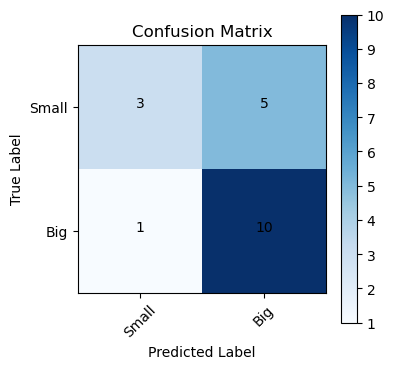

In [44]:
inference.plot_confusion_matrix(words=words_test)

Finally, we plot word embeddings in a 2-dimensional space using TSNE dimensionality reduction which is expected to maintain clusters of points when projecting to lower dimension, but no clear pattern appears.

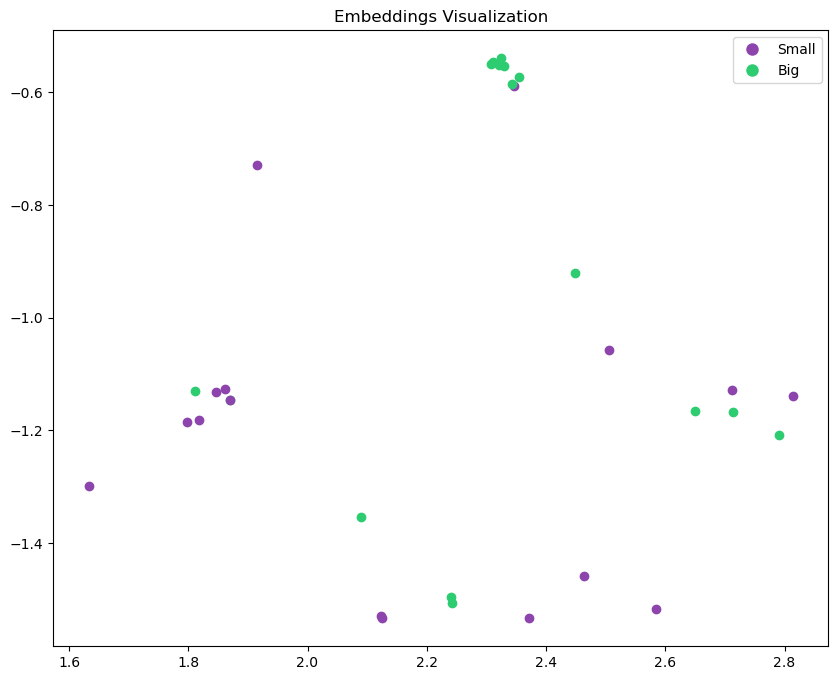

In [45]:
inference.plot_embedding(words=words_experiment)

### Comparison with Human assessment

For each word, let's compare pie charts between the neural network and human subjects. It's important to remember that the two have **entirely different interpretations**. The proportion in the human experiment comes from an average across multiple subjects responding to a certain class, while the neural network directly returns the probability distribution for each class using a softmax.

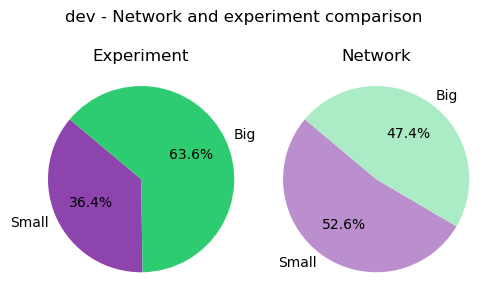

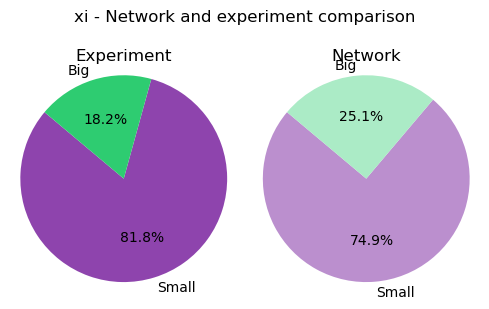

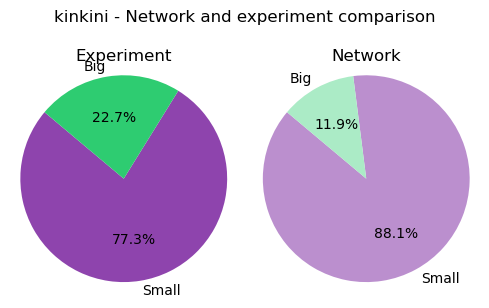

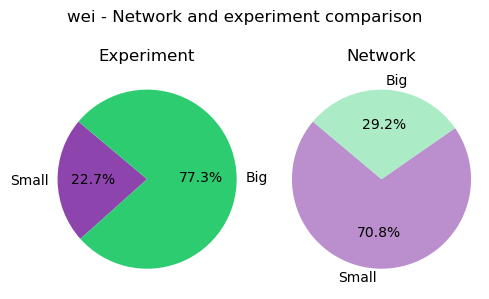

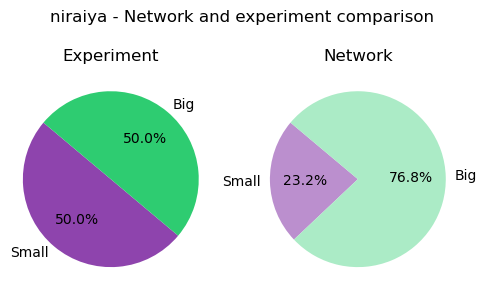

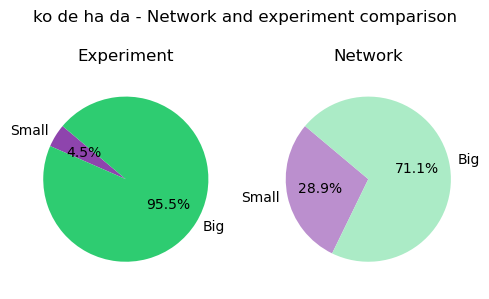

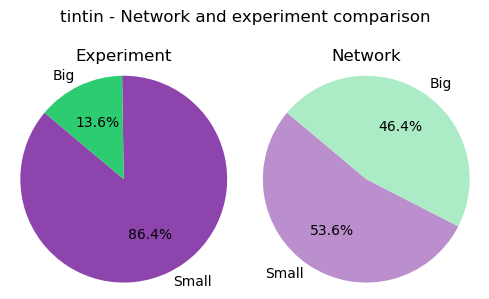

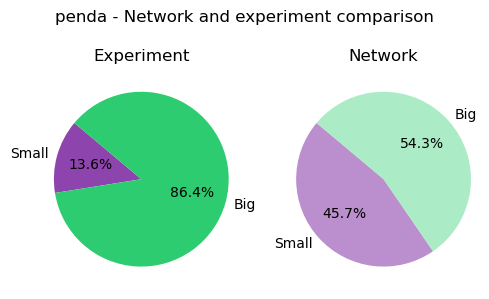

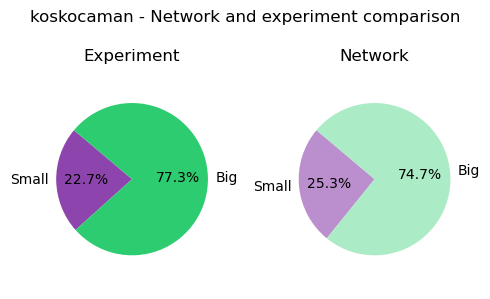

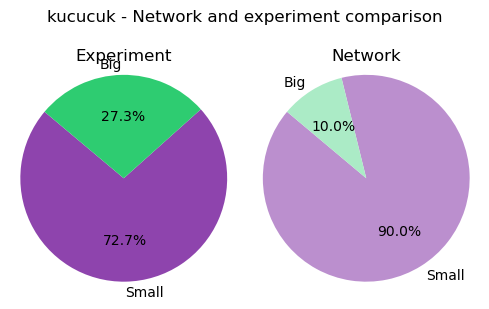

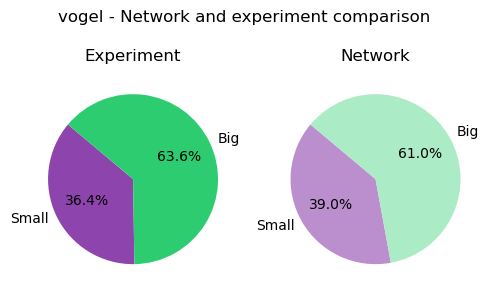

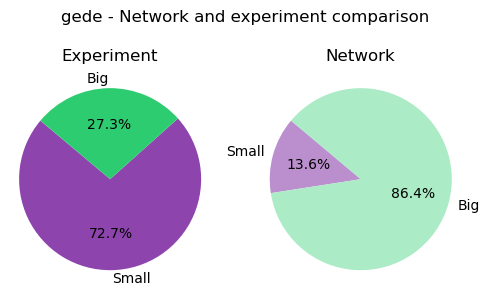

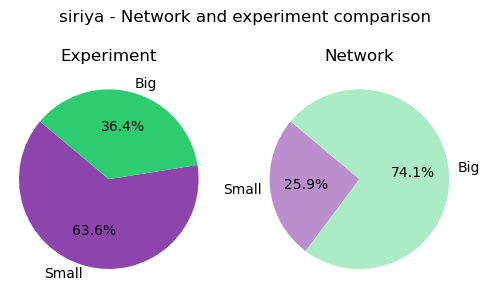

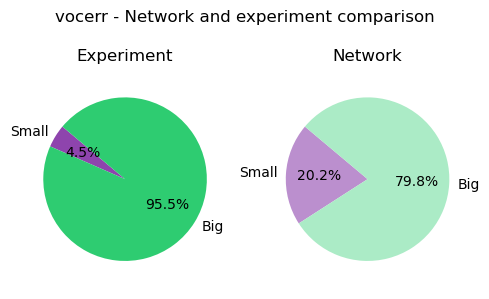

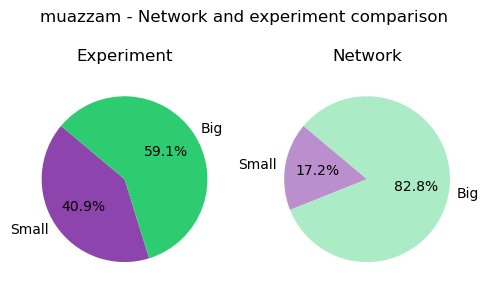

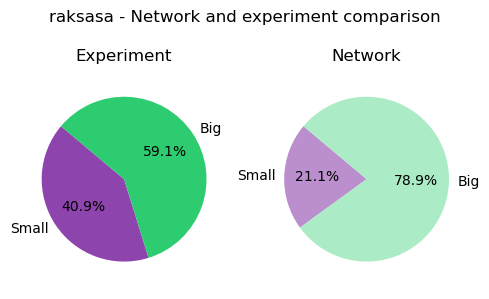

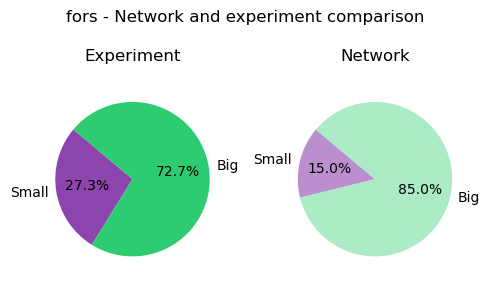

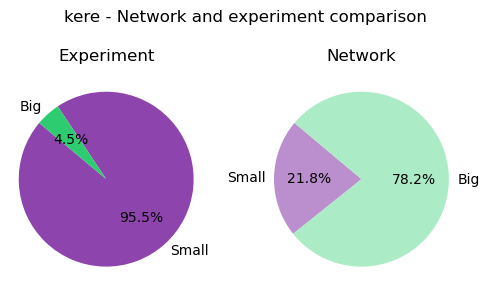

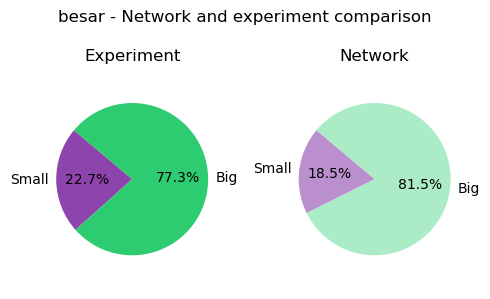

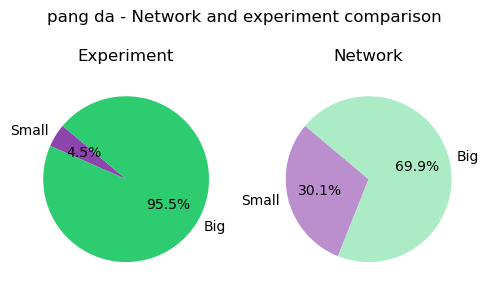

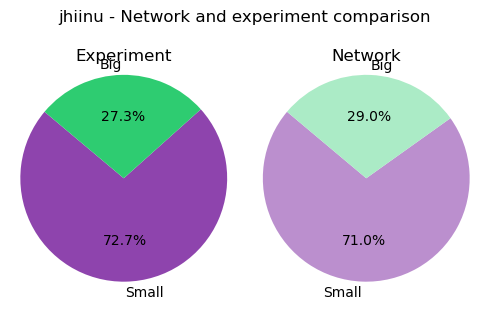

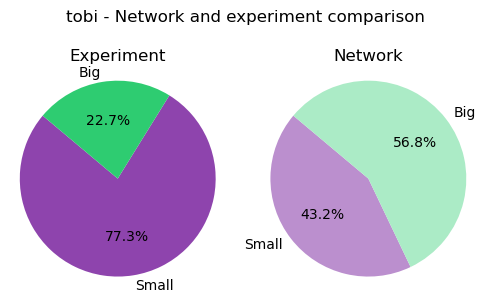

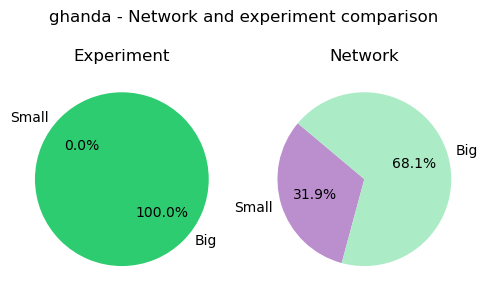

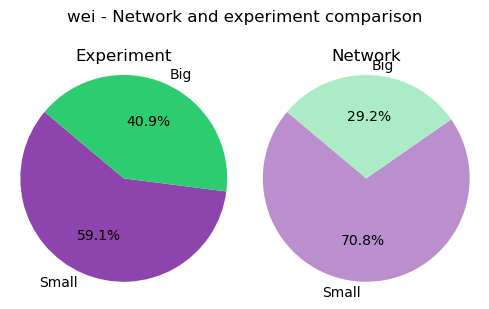

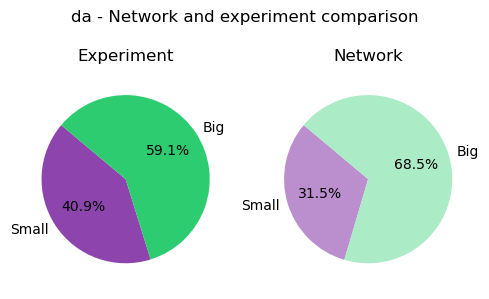

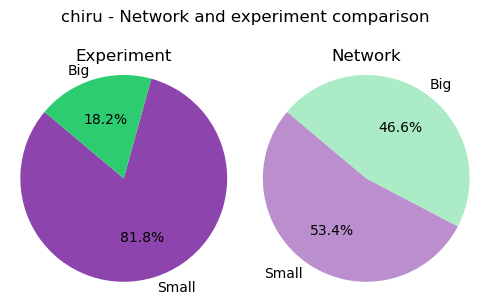

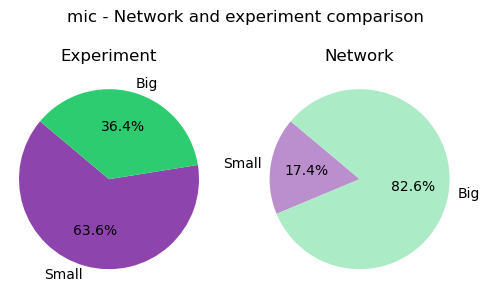

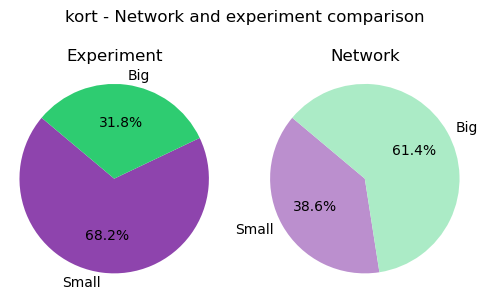

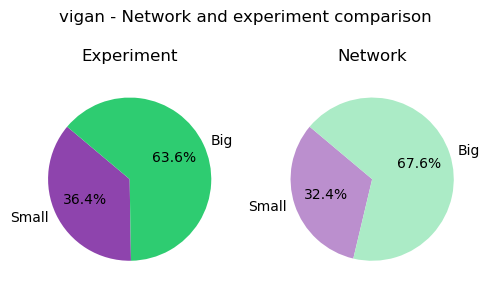

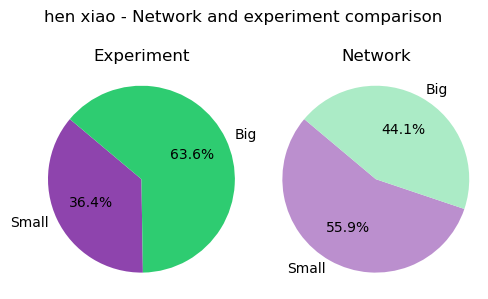

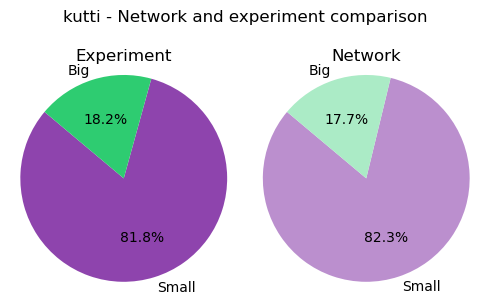

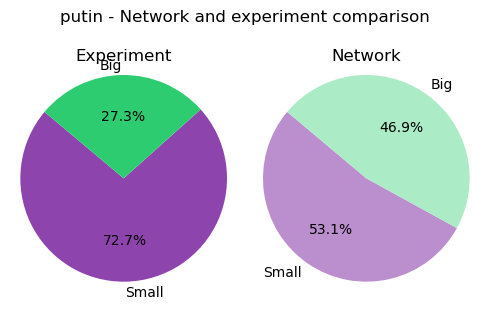

In [46]:
from settings import SMALL_BIG_COLORS, NETWORK_COLORS
from io_ import pie_plot

for word_id, answer in experiments.get_word_answers().items():
    
    word = words_experiment[word_id]
    
    experiment_probs = [count / sum(answer) for count in answer]
    network_probs = inference.predict(word=word.word)
    
    labels = ["Small", "Big"]
    
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))  
    pie_plot(labels=labels, sizes=experiment_probs, colors=SMALL_BIG_COLORS, title="Experiment", ax=axes[0])
    pie_plot(labels=labels, sizes=network_probs,    colors=NETWORK_COLORS, title="Network", ax=axes[1])
    
    fig.suptitle(f"{word.word} - Network and experiment comparison")
    fig.tight_layout()
    plt.show()
    

In certain cases the two have a good matching but this verifies not enough often to state a potential correlation.

Finally, let's see the score of the network if it predicts the most probable class. The accuracy score is exactly the same of the "vowel subject" and it performs worse than only one human subject. This may lead us to believe that the network has been able to **capture some significant dependencies to determine the meaning of the word**, even in a language entirely different from that seen during training.

In [47]:
import numpy as np

rnn_subject = Subject(id_="rnn")

for word in words_experiment:
    
    network_probs = inference.predict(word=word.word)
    pred = np.argmax(network_probs)
    
    answer = Meaning.SMALL if pred == 0 else Meaning.BIG
    
    rnn_subject.add_answer(word_id=word.id_, answer=answer)

rnn_experiment = Experiment(subject=rnn_subject, words=words_experiment)

Let's see the confusion matrix

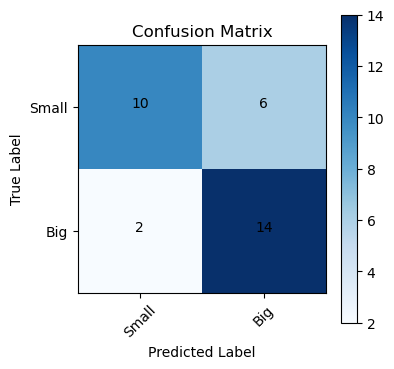

In [48]:
rnn_experiment.plot_confusion_matrix()

In [49]:
print("Accuracies")
print(f"- experiment: {experiments.mean_score}")
print(f"- network:    {rnn_experiment.score}")

Accuracies
- experiment: 0.6463068181818182
- network:    0.75


### 4. Conclusion

In conclusion, both the experiment and the neural network are toy examples that cannot be considered as significant for drawing conclusions. A more formal experimental setup, network modeling, and training dataset would be required. However, the results of this small experiment lead to the speculation that there may be underlying meaning within the arbitrariness of words.